# Evaluation of GRN inference methods
## Explanatory analysis
### by Jalil Nourisa



# Imports

In [2]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
# from mplfonts import use_font

sys.path.insert(0, '../../')
from grn_benchmark.src.helper import surragate_names
from task_grn_inference.src.utils.util import colors_blind
from task_grn_inference.src.exp_analysis.helper import *


# matplotlib.rc('font', family='serif')
# matplotlib.rc('text', usetex='false')

task_grn_inference_dir = '../../task_grn_inference'
results_folder = '../results_folder/'

plt.rcParams['font.family'] = 'Arial'
default_font = matplotlib.rcParams['font.family']
print(default_font)

%matplotlib inline

['Arial']


# Preprocess

In [3]:
if False: # granie extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie.csv')
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/scenicplus/grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/figr/cisCorr.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/figr.csv')

# Build exp models

In [4]:
par = {
    'grn_models': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus'],
        # 'grn_models': [ 'scenicplus'],

    'peak_gene_models': ['celloracle', 'scenicplus', 'figr', 'granie'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/',
    'peak_gene_dir': f'{task_grn_inference_dir}/resources/grn_models/peak_gene',
}

exp_objs_dict = {}
nets_dict = {}

for model in par['grn_models']:
    par['grn_model'] = f"{par['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par['grn_model'])
    
    nets_dict[model] = net

    if model in par['peak_gene_models']:
        peak_gene_net = pd.read_csv(f"{par['peak_gene_dir']}/{model}.csv")
    else:
        peak_gene_net = None
    print(model, len(net))
    obj = Exp_analysis(net, peak_gene_net)
    obj.calculate_basic_stats()
    obj.calculate_centrality()

    exp_objs_dict[model] = obj
exp_objs_dict = {surragate_names[key]:value for key,value in exp_objs_dict.items()}

collectri 43178
negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 64489
scglue 7227
celloracle 50000
figr 52962
granie 50000
scenicplus 41288


# General stats

In [5]:
# regulatory links
links_n = {}
source_n = {}
target_n = {}
ratio_positive_negative_dict = {}
nets = {}

gene_names = ad.read_h5ad(f'{task_grn_inference_dir}/resources/grn-benchmark/multiomics_rna.h5ad').var_names

for name, obj in exp_objs_dict.items():
    net = obj.net
    nets[name] = net
    if 'cell_type' in net.columns: # for cell specific grn models, take the mean
        n_grn = net.groupby('cell_type').size().mean()
    else:
        n_grn = len(net)

    links_n[name] = n_grn
    source_n[name] = obj.stats['n_source']
    target_n[name] = obj.stats['n_target']
    ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']

In [6]:
color_map_methods = {key:color for key, color in zip(exp_objs_dict.keys(), sns.color_palette('Set2', len(exp_objs_dict.keys())))}

# Assign each method a different linestyle
import itertools
line_styles = ['-', '--', '-.', ':']
linestyle_map_methods = {key: linestyle for key, linestyle in zip(exp_objs_dict.keys(), itertools.cycle(line_styles))}

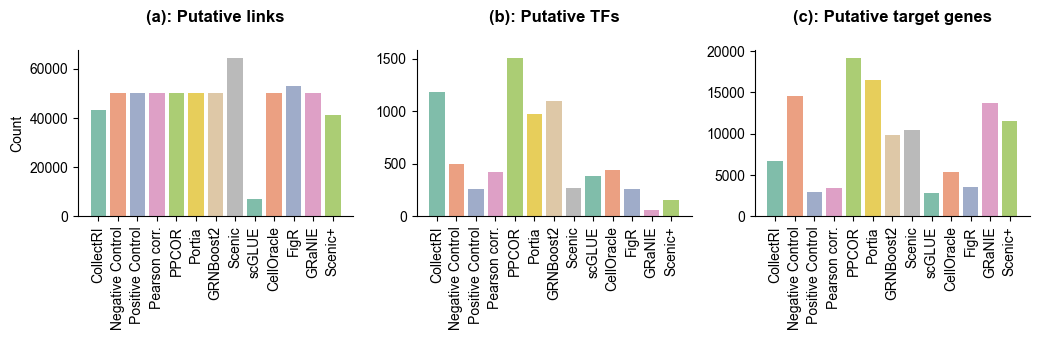

In [7]:
# Prepare data for plotting
data = {
    'Model': [],
    'Count': [],
    'Type': []
}

# Populate the data dictionary for each metric
for model in links_n.keys():
    data['Model'].append(model)
    data['Count'].append(links_n[model])
    data['Type'].append('Putative links')

for model in source_n.keys():
    data['Model'].append(model)
    data['Count'].append(source_n[model])
    data['Type'].append('Putative TFs')

for model in target_n.keys():
    data['Model'].append(model)
    data['Count'].append(target_n[model])
    data['Type'].append('Putative target genes')

# Create a DataFrame from the data dictionary
df = pd.DataFrame(data)

# Create the FacetGrid for separate y-axes
g = sns.FacetGrid(df, col='Type', height=3.5, aspect=1, sharey=False)

# Map the bar plot to each facet
g.map_dataframe(sns.barplot, x='Model', hue='Model', y='Count', palette=color_map_methods, alpha=0.9)

# Customize the plot
g.set_xticklabels(rotation=90)
g.set_axis_labels("", "Count")
# g.fig.suptitle("Gene Regulatory Network Statistics", y=1.05)

# Use ax.margins to set margins on the x-axis
for ax in g.axes.flat:
    ax.margins(x=0.05)  # Adjust the margin fraction as needed

# Remove the default titles and set custom titles without 'Type='
prefixes = ['(a)', '(b)', '(c)']
for i, ax in enumerate(g.axes.flat):
    title = ax.get_title().replace('Type = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
    ax.set_title(title, pad=20, fontsize=12, fontweight='bold')

# Remove spines for better aesthetics
for ax in g.axes.flat:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/stats.png', dpi=300, transparent=True)

CellOracle
FigR
GRaNIE
Scenic+


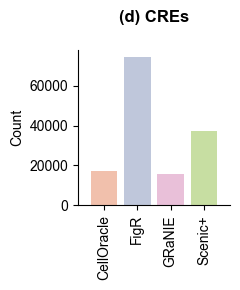

In [8]:
if True:
    # peaks
    peaks_dict = {}
    peaks_n_dict = {}
    for name, obj in exp_objs_dict.items():
        if obj.peak_gene_net is None:
            continue 
        df = obj.peak_gene_net
        print(name)
        try:
            peaks_dict[name] = df.peak.unique()
            peaks_n_dict[name] = df.peak.nunique()
        except:
            peaks_dict[name] = df.source.unique()
            peaks_n_dict[name] = df.source.nunique()
        df = pd.DataFrame({
    'Model': peaks_n_dict.keys(),
    'Count': peaks_n_dict.values()
})

# Plot with Seaborn
plt.figure(figsize=(2.5, 3))
ax = sns.barplot(x='Model', hue='Model', y='Count', data=df, palette=color_map_methods, alpha=0.6)

# Customize labels and ticks
ax.set_ylabel('Count')
ax.set_title('(d) CREs', pad=20,fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)

ax.margins(x=0.1)

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Adjust layout
plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/stats_cres.png', dpi=300, transparent=True)

#### Regulatory signs

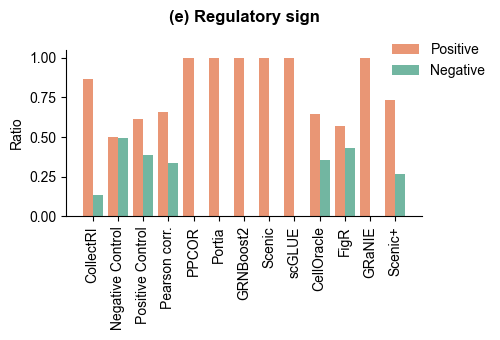

In [9]:
data = ratio_positive_negative_dict
models = list(data.keys())
positive_r = [p for p in data.values()]
negative_r = [1 - p for p in data.values()]


df = pd.DataFrame({
    'Model': models * 2,  # Repeat model names for both Positive and Negative
    'Ratio': positive_r + negative_r,  # Concatenate positive and negative ratios
    'Regulatory Sign': ['Positive'] * len(models) + ['Negative'] * len(models)  # Label each as Positive or Negative
})

# Set Seaborn theme
# sns.set(style="whitegrid")  


# Create bar plot using Seaborn
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
sns.barplot(x='Model', y='Ratio', hue='Regulatory Sign', data=df, width=.8,
            palette=[list(color_map_methods.values())[1], list(color_map_methods.values())[0]], ax=ax)

# Customize labels and ticks
ax.set_ylabel('Ratio')
ax.tick_params(axis='x', rotation=90)
ax.margins(x=0.05)
ax.set_xlabel('')
ax.set_title('(e) Regulatory sign', pad=20, fontsize=12, fontweight='bold')


# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Grid and legend
# ax.grid(alpha=0.3, linestyle='--', linewidth=.5, color='grey')
ax.legend(frameon=False, loc=(.9, .8))
plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/regulatory_signs.png', dpi=300, transparent=True)


### CDF

In [10]:
# # tf gene: in degree
# fig, axes = plt.subplots(1, 4, figsize=(12, 2.5))
# for i_plot, (name, obj) in enumerate(exp_objs_dict.items()):
#     if i_plot < 3:
#         ax = axes[0]
#     elif i_plot < 6:
#         ax = axes[1]
#     elif i_plot < 9:
#         ax = axes[2]
#     else:
#         ax = axes[3]
#     obj.plot_grn_cdf(ax)
#     ax.lines[-1].set_label(name)
#     ax.legend(frameon=False)
#     # ax.set_xlim([-.02,.3])
#     # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
# plt.tight_layout()

# Jaccard similarity 

In [11]:
del nets['CollectRI']
del nets['Negative Control']
del nets['GRaNIE']
del nets['PPCOR']

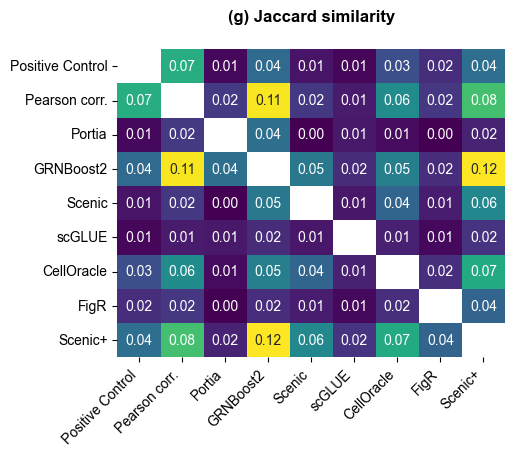

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
_ = jaccard_similarity_net(nets, ax=ax)
ax.set_title('(g) Jaccard similarity', pad=20, fontsize=12, fontweight='bold')
plt.savefig(f'{results_folder}/explanatory_analysis/figs/jaccard_similarity.png', dpi=300, transparent=True, bbox_inches='tight')


# Skeleton

In [63]:
skeleton =  pd.read_csv(f'{task_grn_inference_dir}/resources/prior/skeleton.csv')
skeleton_promotor = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/skeleton_promotor.csv')

In [55]:
grn = pd.read_csv('../../task_grn_inference/resources/grn_models/celloracle.csv')

In [58]:
grn[~(grn.source.isin(skeleton_promotor.source)&grn.target.isin(skeleton_promotor.target))]

,Unnamed: 0.1,Unnamed: 0,source,target,weight
1,39312,39312,ITGB2,TYROBP,0.498001
3,39126,39126,ITGB2,IFI30,0.465973
10,23069,23069,ENO1,RPL13,0.380924
24,23072,23072,ENO1,RPLP1,0.341765
30,23073,23073,ENO1,RPS23,0.330364
...,...,...,...,...,...
49927,58749,58749,NF1,LPIN2,0.015345
49952,39052,39052,ITGB2,BAZ2A,0.015341
49957,9131,9131,CCNT2,CNOT4,0.015340
49972,1720,1720,AHRR,FAM241A,0.015337


In [60]:
skeleton_promotor['link'] = skeleton_promotor['source'] + '_' + skeleton_promotor['target']

In [48]:
links_promotor = ['_'.join(link.split(',')[1:]) for link in skeleton_promotor]
links_skeleton = ['_'.join(link.split(',')[1:]) for link in skeleton]

In [70]:
ratio_in_skeleton_dict = {}
ratio_in_promotor_dict = {}

for name, obj in exp_objs_dict.items():
    # skeleton 
    net = obj.net[obj.net.target.isin(gene_names)]
    matches = pd.merge(net[['source', 'target']], skeleton[['source', 'target']], 
                   on=['source', 'target'], how='inner')
    in_count = len(matches)
    ratio_in_skeleton_dict[name] = in_count/len(net)
    # promotor 
    matches = pd.merge(net[['source', 'target']], skeleton_promotor[['source', 'target']], 
                   on=['source', 'target'], how='inner')
    in_count = len(matches)
    ratio_in_promotor_dict[name] = in_count/len(net)

KeyboardInterrupt: 

In [68]:
ratio_in_skeleton_dict['CellOracle']

0.82688

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_96102/1426171357.py:18: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  g = sns.barplot(x='Model', y='Ratio', hue='Skeleton Status', data=df, width=.8,


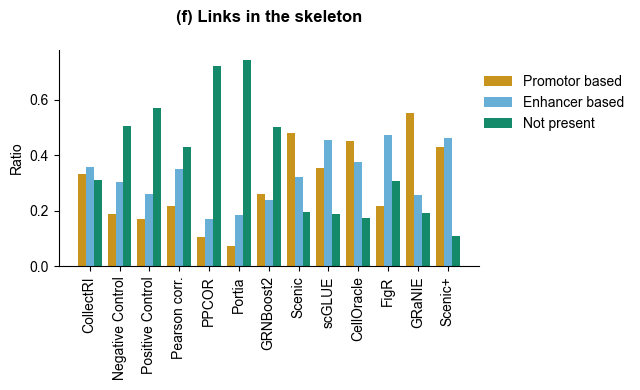

In [69]:
colors = sns.color_palette()
# Data preparation
models = list(ratio_in_skeleton_dict.keys())
in_promotor_r = [p for p in ratio_in_promotor_dict.values()]
in_skeleton_r = [p for p in ratio_in_skeleton_dict.values()]
in_enhancer_r = list(np.array(in_skeleton_r)-np.array(in_promotor_r))
not_in_skeleton_r = [1 - p for p in ratio_in_skeleton_dict.values()]

# Create a DataFrame suitable for Seaborn
df = pd.DataFrame({
    'Model': models * 3,  # Repeat model names for both 'In skeleton' and 'Not in skeleton'
    'Ratio': in_promotor_r + in_enhancer_r + not_in_skeleton_r ,  # Concatenate the positive and negative ratios
    'Skeleton Status': ['Promotor based'] * len(models) +  ['Enhancer based'] * len(models) + ['Not present'] * len(models)  # Label for each bar
})

# Create bar plot using Seaborn
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
g = sns.barplot(x='Model', y='Ratio', hue='Skeleton Status', data=df, width=.8,
            palette=colors_blind, ax=ax)

# Customize labels and ticks
ax.set_ylabel('Ratio')
ax.tick_params(axis='x', rotation=90)

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Grid and legend
ax.legend(frameon=False, loc=(1, .6))
g.axes.margins(x=0.05)
g.axes.set_xlabel('')
ax.set_title('(f) Links in the skeleton', pad=20, fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/in_skeleton.png', dpi=300, transparent=True)


In [35]:
colors_blind

['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

# Connectivity

#### Centrality

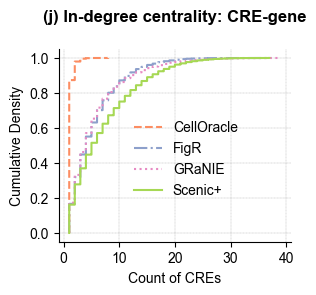

In [17]:
if True:
    # peak gene: in degree
    fig, ax = plt.subplots(figsize=(3, 2.5))
    for name, obj in exp_objs_dict.items():
        if obj.peak_gene_net is None:
            continue 
        
        values = exp_objs_dict[name].peak_gene.in_deg.degree.values
        obj.plot_cumulative_density(values, title=name, x_label='Count of CREs', ax=ax, linestyle=linestyle_map_methods[name], c=color_map_methods[name], alpha=1, label=name)
    ax.legend(frameon=False,  loc=(.3, .2))
    ax.set_title('(j) In-degree centrality: CRE-gene', pad=20, fontsize=12, fontweight='bold')
    
    fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_peakgene.png', dpi=300, transparent=True,  bbox_inches='tight')



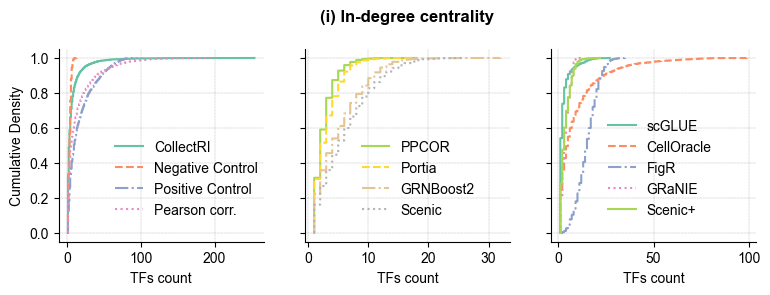

In [18]:
# tf gene: in degree
fig, axes = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)
for i_plot, (name, obj) in enumerate(exp_objs_dict.items()):
    obj.calculate_centrality()
    values = obj.tf_gene.in_deg.degree.values
    if i_plot < 4:
        ax = axes[0]
    elif i_plot < 8:
        ax = axes[1]
    else:
        ax = axes[2]
    obj.plot_cumulative_density(values, title='', x_label='TFs count', ax=ax, alpha=1, label=name, s=5, c=color_map_methods[name], linestyle=linestyle_map_methods[name])
    if i_plot > 4:
        ax.set_ylabel('')
    ax.legend(frameon=False, loc=(.25, .1))
    # ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
# plt.tight_layout()
axes[1].set_title('(i) In-degree centrality', pad=20, fontsize=12, fontweight='bold')

fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_in.png', dpi=300, transparent=True,  bbox_inches='tight')

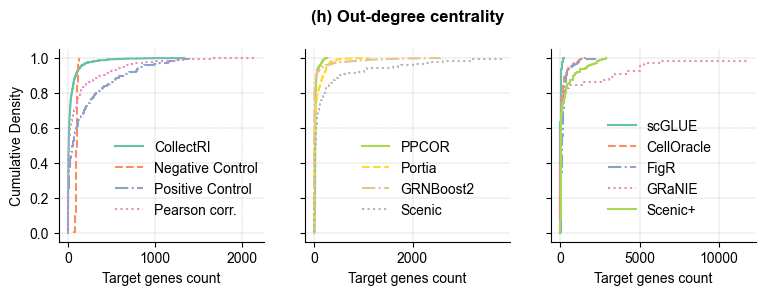

In [19]:
# tf gene: in degree
fig, axes = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)
for i_plot, (name, obj) in enumerate(exp_objs_dict.items()):
    obj.calculate_centrality()
    values = obj.tf_gene.out_deg.degree.values
    if i_plot < 4:
        ax = axes[0]
    elif i_plot < 8:
        ax = axes[1]
    else:
        ax = axes[2]
    obj.plot_cumulative_density(values, title='', x_label='Target genes count', ax=ax, alpha=1, label=name, s=5, c=color_map_methods[name], linestyle=linestyle_map_methods[name])
    if i_plot > 4:
        ax.set_ylabel('')
    ax.legend(frameon=False, loc=(.25, .1))
    # ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
# plt.tight_layout()
axes[1].set_title('(h) Out-degree centrality', pad=20, fontsize=12, fontweight='bold')
fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_out.png', dpi=300, transparent=True,  bbox_inches='tight')

### Intersection of GRN elements

In [20]:
# Create a set of all unique genes
if False:
    # interaction_info = create_interaction_info({key:exp_objs_dict[key] for key in ['Scenic+', 'GRNBoost2', 'Positive Control']})
    interaction_info = create_interaction_info(exp_objs_dict)
    fig = plot_interactions(interaction_info['links'], min_subset_size = 1000, min_degree=3, color_map=None)    
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/links_interactions.png', dpi=300, transparent=True,  bbox_inches='tight')
    fig = plot_interactions(interaction_info['source'], min_subset_size = 10, min_degree=3, color_map=None) 
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/TFs_interactions.png', dpi=300, transparent=True, bbox_inches='tight')
    fig = plot_interactions(interaction_info['target'], min_subset_size = 10, min_degree=3, color_map=None) 
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/targets_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

In [21]:
aaa

NameError: name 'aaa' is not defined

# Annoation

### Annotate peaks

In [63]:
annotation_df = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_dict.items():
    obj.annotate_peaks(annotation_df)

Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Not all peaks in the net is among the annotated ones. Finding the overlap


#### Plot

In [65]:
annotation_dict = {}
for name, obj in exp_objs_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Promoter,Intron,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
CellOracle,98.5,0.6,0.3,0.2,0.1,0.0
FigR,30.4,37.8,18.0,6.7,4.7,1.5
GRaNIE,66.2,15.8,10.4,4.0,2.3,0.9
Scenic+,35.1,34.4,17.3,6.8,4.4,1.2


In [115]:
peak_annotation_df = peak_annotation_df.reindex(['FigR', 'CellOracle', 'GRaNIE', 'Scenic+'])

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),


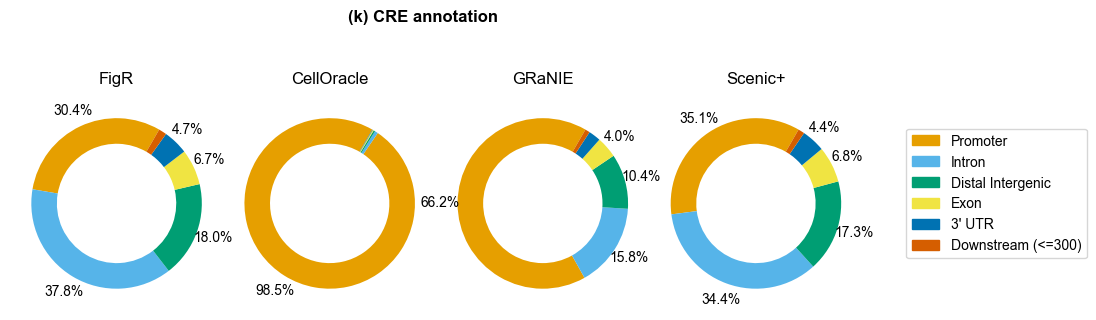

In [182]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{results_folder}/explanatory_analysis/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()